In [52]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os 
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import sys
from tqdm.notebook import tqdm

sns.set(style="whitegrid", context='paper', color_codes=False)
from plotResults import *

# Import ML pipeline results data frame

In [70]:
CONFOUND_FOLDER="posthoc-cc-fu2-anxdx-total-n634"
DATE_TIME="20220131-1948"

df = pd.read_csv(f"/ritter/share/projects/Lab_Rotation_Milena/MLpipelines/results/{CONFOUND_FOLDER}/{DATE_TIME}/run.csv")

# Import confound data frame

In [71]:
# the analysis timepoint (timepoint of imaging data X) to look into 
TP = "FU2" # "FU2", "BL"  

In [72]:
INSTRU_QUESTIONNAIRE="ANXDX"
INSTRU_QUESTION="Total"

# a unique name for the instrument to save filenames 
from slugify import slugify
INSTRU_NAME = slugify(INSTRU_QUESTIONNAIRE +'_'+ INSTRU_QUESTION)
print("Variable controlling for::", INSTRU_NAME.title())

instrument_df = pd.read_csv(f"/ritter/share/data/IMAGEN/posthoc/all_{INSTRU_QUESTIONNAIRE}.csv").set_index('ID')

if TP == "FU3":
    instrument_df = instrument_df.groupby('Session').get_group('FU3')
elif TP == "FU2":
    instrument_df = instrument_df.groupby('Session').get_group('FU2')
elif TP == "FU1":
    instrument_df = instrument_df.groupby('Session').get_group('FU1')
elif TP == "BL":
    instrument_df = instrument_df.groupby('Session').get_group('BL')
    
# compute median
instrument_df[INSTRU_QUESTION].median()

Variable controlling for:: Anxdx-Total


5.0

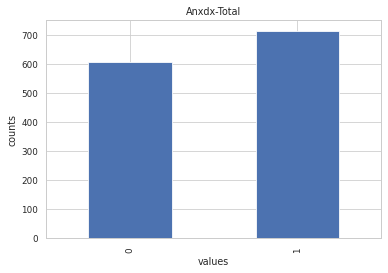

In [73]:
instrument_df = instrument_df[INSTRU_QUESTION]

# binarize the question ####adapt!
instrument = instrument_df.copy()
instrument[instrument_df<5] =  0
instrument[instrument_df>=5] = 1

instrument.value_counts(dropna=False).sort_index().plot.bar(title=INSTRU_NAME.title(), xlabel='values', ylabel='counts')

plt.show()

In [74]:
# import the data loader
sys.path.append("../")
from imagen_dataloader import *

VIZ=False
imagen = Imagen()

# add the instrument as a confound variable
imagen.df.loc[:, (TP,INSTRU_NAME)] = instrument
# for subjects missing this information, force the value to the majority class. This is a temporary workaround but may not be true, of course
imagen.df.loc[:, (TP,INSTRU_NAME)] = imagen.df.loc[:, (TP,INSTRU_NAME)].fillna(0)

# load the 'Binge drinking' label from ESPAD questionnaire's 19a question
LBL_QUESTIONNAIRE="ESPAD_FU3"
LBL_QUESTION="19a"
LABEL_NAME = 'Binge'

dfq = pd.read_csv(qs[LBL_QUESTIONNAIRE], usecols=["User code", LBL_QUESTION], dtype={"User code":str})
dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
dfq = dfq.drop("User code", axis=1)
imagen.load_label(dfq, col=LBL_QUESTION, binarize=True, class0=3, class1=6, y_colname=LABEL_NAME, viz=False)

imagen.prepare_X(TP, confs=['sex', 'site', INSTRU_NAME], viz=VIZ) 
imagen.hdf5_name_x = 'posthoc-cc-'

Final dataframe prepared. 
Total subjects = 634


In [75]:
instrument_df

ID
112288       0
215284       8
240546       4
297685       2
308867       1
            ..
99677574     0
99873252     0
99875982    11
99930021     5
99954902     3
Name: Total, Length: 1321, dtype: int64

# Plot confound distribution and ML results

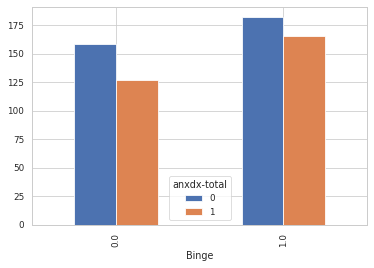

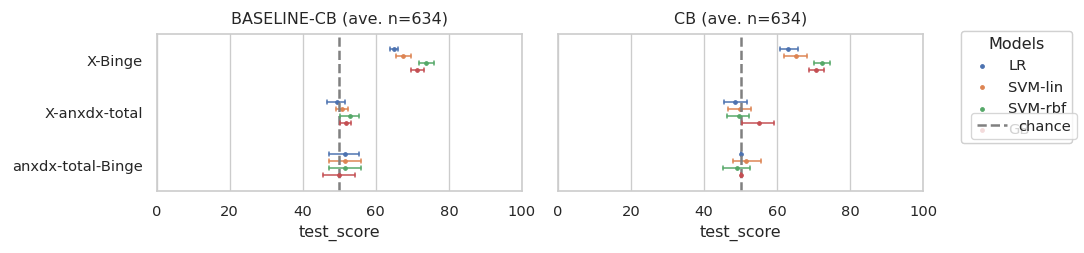

In [76]:
imagen.df_out[[LABEL_NAME, INSTRU_NAME]].value_counts().unstack().plot.bar()
plot_result(df, x="test_score", beautify_io=False)
plt.show()

# Compare numerical accuracies

In [77]:
df = pd.read_csv(f"/ritter/share/projects/Lab_Rotation_Milena/MLpipelines/results/{CONFOUND_FOLDER}/{DATE_TIME}/run.csv")

# Linear Regression
df_LR_BL = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'baseline-cb') & (df['model'] == 'LR')]
df_LR_CB = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'cb') & (df['model'] == 'LR')]
# Linear SVM
df_LSVM_BL = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'baseline-cb') & (df['model'] == 'SVM-lin')]
df_LSVM_CB = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'cb') & (df['model'] == 'SVM-lin')]
# Gradient Boosting
df_GB_BL = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'baseline-cb') & (df['model'] == 'GB')]
df_GB_CB = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'cb') & (df['model'] == 'GB')]
# Non-linear SVM
df_NLSVM_BL = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'baseline-cb') & (df['model'] == 'SVM-rbf')]
df_NLSVM_CB = df.loc[(df['io'] == 'X-Binge') & (df['technique'] == 'cb') & (df['model'] == 'SVM-rbf')]


In [78]:
# initialize data of lists
acc_data = {# 'Confound':['combined BIS & PSS & NEO Extro', 'combined BIS & PSS & NEO Extro', 'combined BIS & PSS & NEO Extro',
            #         'combined BIS & PSS & NEO Extro'],
             'Confound':[f'{INSTRU_QUESTIONNAIRE}_{INSTRU_QUESTION}', f'{INSTRU_QUESTIONNAIRE}_{INSTRU_QUESTION}',
                     f'{INSTRU_QUESTIONNAIRE}_{INSTRU_QUESTION}', f'{INSTRU_QUESTIONNAIRE}_{INSTRU_QUESTION}'],
            'TP':[f'{TP}', f'{TP}', f'{TP}', f'{TP}'],
            'Model':['Linear Regression', 'Linear SVM', 'Gradient Boosting', 'Kernel SVM'], 
            'Accuracy Baseline-CB':[df_LR_BL['test_score'].mean(), df_LSVM_BL['test_score'].mean(), df_GB_BL['test_score'].mean(), 
                                    df_NLSVM_BL['test_score'].mean()], 
            'Accuracy CB':[df_LR_CB['test_score'].mean(), df_LSVM_CB['test_score'].mean(), df_GB_CB['test_score'].mean(), 
                           df_NLSVM_CB['test_score'].mean()],
            'Accuracy Diff CB - BL':[df_LR_CB['test_score'].mean()-df_LR_BL['test_score'].mean(), 
                                    df_LSVM_CB['test_score'].mean()-df_LSVM_BL['test_score'].mean(),
                                    df_GB_CB['test_score'].mean()-df_GB_BL['test_score'].mean(),
                                    df_NLSVM_CB['test_score'].mean()-df_NLSVM_BL['test_score'].mean()]}
 
# Create DataFrame
acc_df = pd.DataFrame(acc_data)

In [79]:
acc_df

,Confound,TP,Model,Accuracy Baseline-CB,Accuracy CB,Accuracy Diff CB - BL
0,ANXDX_Total,FU2,Linear Regression,0.650493,0.630821,-0.019672
1,ANXDX_Total,FU2,Linear SVM,0.674840,0.650144,-0.024695
2,ANXDX_Total,FU2,Gradient Boosting,0.713653,0.706851,-0.006801
3,ANXDX_Total,FU2,Kernel SVM,0.737960,0.723331,-0.014628


In [80]:
# just for first variable
# acc_df.to_csv(f'/ritter/share/projects/Lab_Rotation_Milena/posthoc_analysis/accuracy.csv', index=False)

In [81]:
# read general accuracy file containing accuracy changes for all confounds
acc_total = pd.read_csv('/ritter/share/projects/Lab_Rotation_Milena/posthoc_analysis/accuracy.csv')

In [82]:
# delete specific rows
# acc_new = acc_total.loc[acc_total["Confound"] != 'LEQ_Sexuality mean frequency']
# acc_new = acc_total.loc[(acc_total['TP'] != 'BL') & (acc_total['Confound'] != 'ESPAD_Alc_Expectancy Total')]

In [83]:
# concatenate new accuracy df to general accuracy file
acc_new = pd.concat([acc_total, acc_df])

In [84]:
acc_new

,Confound,TP,Model,Accuracy Baseline-CB,Accuracy CB,Accuracy Diff CB - BL
0,BIS_BIS Total,FU3,Linear Regression,0.623891,0.592944,-0.030947
1,BIS_BIS Total,FU3,Linear SVM,0.654336,0.618104,-0.036233
2,BIS_BIS Total,FU3,Gradient Boosting,0.678009,0.644950,-0.033060
3,BIS_BIS Total,FU3,Kernel SVM,0.692938,0.667005,-0.025933
4,ESPAD_first_drunk_fd,FU3,Linear Regression,0.623891,0.605564,-0.018327
...,...,...,...,...,...,...
167,combined BIS & PSS & NEO Extro,FU3,Kernel SVM,0.692938,0.678441,-0.014497
0,ANXDX_Total,FU2,Linear Regression,0.650493,0.630821,-0.019672
1,ANXDX_Total,FU2,Linear SVM,0.674840,0.650144,-0.024695
2,ANXDX_Total,FU2,Gradient Boosting,0.713653,0.706851,-0.006801


In [85]:
# save concatenated file
acc_new.to_csv('/ritter/share/projects/Lab_Rotation_Milena/posthoc_analysis/accuracy.csv', index=False)